# Creating a neural net with mulitple layers, activation functions from scratch.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

## Function to generate data that we can then test on

In [4]:
def spiral_data(points, classes):
    X = np.zeros((points*classes, 2))
    y = np.zeros(points*classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(points*class_number, points*(class_number+1))
        r = np.linspace(0.0, 1, points)  # radius
        t = np.linspace(class_number*4, (class_number+1)*4, points) + np.random.randn(points)*0.2
        X[ix] = np.c_[r*np.sin(t*2.5), r*np.cos(t*2.5)]
        y[ix] = class_number
    return X, y

In [5]:
def sine_data(samples=1000):
    X = np.arange(samples).reshape(-1, 1) / samples
    y = np.sin(2 * np.pi * X).reshape(-1, 1)

    return X, y

### Call the function to generate data and plot it.

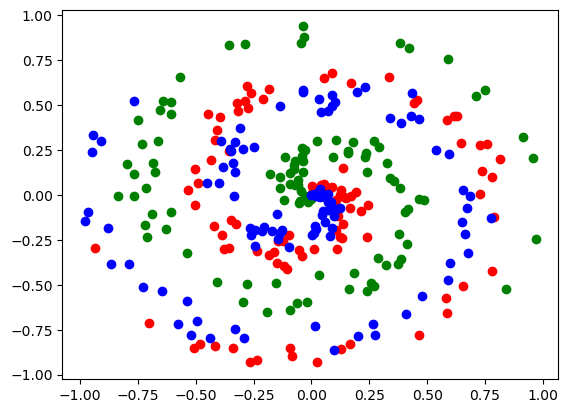

In [6]:
X, y = spiral_data(100, 3)
class_colors = ['red', 'green', 'blue']
for i in range(3):
    class_data = [data[0] for data in zip(X,y) if data[1] == i]
    plt.scatter([data[0] for data in class_data], [data[1] for data in class_data], color=class_colors[i], label=f'Class {i}')

## Activation Functions

In [7]:
class Sigmoid_Activation:
    def forward_pass(self, inputs, training):
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-inputs))
    
    def backward_pass(self, dvalues):
        self.dinputs = dvalues * (1 - self.output) * self.output

    def predictions(self, outputs):
        return (outputs > 0.5) * 1

In [8]:
class Relu_Activation:
    def forward_pass(self, inputs, training):
        self.inputs = inputs
        self.output = np.maximum(0,inputs)
    
    def backward_pass(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
    
    def predictions(self, outputs):
        return outputs

In [9]:
class Softmax_Activation:
    def forward_pass(self, inputs, training):
        self.inputs = inputs
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        
    def backward_pass(self, dvalues):
        self.dinputs = np.empty_like(dvalues)
        for index, (single_output, single_dvalues) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1,1)
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T)
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)
    
    def predictions(self, outputs):
        return np.argmax(outputs, axis=1)

In [10]:
class Linear_Activation:
    def forward_pass(self, inputs, training):
        self.inputs = inputs
        self.output = inputs
        
    def backward_pass(self, dvalues):
        self.dinputs = dvalues.copy()
    
    def predictions(self, outputs):
        return outputs

## Layers

In [12]:
class Input_Layer:
    def forward_pass(self, inputs, training):
        self.output = inputs

In [11]:
class Dense_Layer:
    def __init__(self, n_inputs, n_neurons, weight_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l1=0, bias_regularizer_l2=0):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
        
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward_pass(self, inputs, training):
        self.output = np.dot(inputs, self.weights) + self.biases
        self.inputs = inputs
    
    def backward_pass(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dinputs = np.dot(dvalues, self.weights.T)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weight)
            dL1[self.weights < 0] = -1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
            
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] = -1
            self.dbiases += self.bias_regularizer_l1 * dL1

        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

In [13]:
class Dropout_Layer:
    def __init__(self, rate):
        self.rate = 1 - rate
        
    def forward_pass(self, inputs, training):
        self.inputs = inputs
        
        if not training:
            self.output = inputs.copy()
            return
        
        self.binary_mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        self.output = inputs * self.binary_mask
    
    def backward_pass(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

## Loss Classes

In [14]:
class Loss:
    def remember_trainable_layers(self, trainable_layers):
        self.trainable_layers = trainable_layers
    
    def calculate(self, output, y, *, include_regularization=False):
        sample_losses = self.forward_pass(output, y)
        data_loss = np.mean(sample_losses)
        
        self.accumulated_sum += np.sum(sample_losses)
        self.accumulated_count += len(sample_losses)
        
        if not include_regularization:
            return data_loss
        
        return data_loss, self.regularization_loss()
    
    def calculate_accumulated(self, *, include_regularization=False):
        data_loss = self.accumulated_sum / self.accumulated_count
        
        if not include_regularization:
            return data_loss
        
        return data_loss, self.regularization_loss()
    
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0
    
    def regularization_loss(self):
        regularization_loss = 0
        
        for layer in self.trainable_layers:
            if layer.weight_regularizer_l1 > 0:
                regularization_loss += layer.weight_regularizer_l1 * np.sum(abs(layer.weights))

            if layer.weight_regularizer_l2 > 0:
                regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights * layer.weights)

            if layer.bias_regularizer_l1 > 0:
                regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

            if layer.bias_regularizer_l2 > 0:
                regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.biases * layer.biases)
            
        return regularization_loss
    
class Categorical_CrossEntropy(Loss):
    def forward_pass(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
                
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped*y_true, axis=1)
        
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods
    
    def backward_pass(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        self.dinputs = -y_true / dvalues
        self.dinputs = self.dinputs / samples

class Binary_Crossentropy(Loss):
    def forward_pass(self, y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        sample_losses = -(y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
        sample_losses = np.mean(sample_losses, axis=-1)
        return sample_losses

    def backward_pass(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        clipped_dvalues = np.clip(dvalues, 1e-7, 1 - 1e-7)
        self.dinputs = -(y_true / clipped_dvalues - (1 - y_true) / (1 - clipped_dvalues)) / outputs
        self.dinputs = self.dinputs / samples

class MeanSquared_Error(Loss):
    def forward_pass(self, y_pred, y_true):
        sample_losses = np.mean((y_true - y_pred) ** 2, axis=-1)
        return sample_losses
    
    def backward_pass(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples
        
class MeanAbsolute_Error(Loss):
    def forward_pass(self, y_pred, y_true):
        sample_losses = np.mean(np.abs(y_true - y_pred), axis=-1)
        return sample_losses

    def backward_pass(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        self.dinputs = np.sign(y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [26]:
class Combined_Softmax_Categorical_CrossEntropy:
    def __init__(self):
        self.activation = Softmax_Activation()
        self.loss = Categorical_CrossEntropy()
    
    def forward_pass(self, inputs, y_true):
        self.activation.forward_pass(inputs, training=True)
        self.output = self.activation.output
        return self.loss.calculate(self.output, y_true)
    
    def backward_pass(self, dvalues, y_true):
        samples = len(dvalues)
        
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
            
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

In [16]:
class Accuracy:
    def calculate(self, predictions, y):
        comparisons = self.compare(predictions, y)
        accuracy = np.mean(comparisons)
        
        self.accumulated_sum += np.sum(comparisons)
        self.accumulated_count += len(comparisons)
        
        return accuracy

    def calculate_accumulated(self):
        accuracy = self.accumulated_sum / self.accumulated_count
        return accuracy
        
    def new_pass(self):
        self.accumulated_sum = 0
        self.accumulated_count = 0

class Accuracy_Regression(Accuracy):
    def __init__(self):
        self.precision = None
        
    def init(self, y, reinit=False):
        if self.precision is None or reinit:
            self.precision = np.std(y) / 250
            
    def compare(self, predictions, y):
        return np.absolute(predictions - y) < self.precision
    
class Accuracy_Categorical(Accuracy):
    def init(self, y):
        pass
    
    def compare(self, predictions, y):
        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)
            
        return predictions == y

## Optimizers

In [17]:
class SGD_Optimizer:
    def __init__(self, learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
    
    def update_params(self, layer):
        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
        
        layer.weights += weight_updates
        layer.biases += bias_updates
    
    def post_update_params(self):
        self.iterations += 1

In [18]:
class AdaGrad_Optimizer:
    def __init__(self, learning_rate=1.0, decay=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.epsilon = epsilon
        self.iterations = 0
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache += layer.dweights**2
        layer.bias_cache += layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

In [19]:
class RMS_Prop_Optimizer:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, rho=0.9):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            
        layer.weight_cache = self.rho * layer.weight_cache + (1 - self.rho) * layer.dweights**2
        layer.bias_cache = self.rho * layer.bias_cache + (1 - self.rho) * layer.dbiases**2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.current_learning_rate * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

In [20]:
class Adam_Optimizer:
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
    
    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
    
    def post_update_params(self):
        self.iterations += 1

## Creating a Model Class

In [108]:
class Model:
    def __init__(self):
        self.layers = []
        self.softmax_classifier_output = None
        
    def add(self, layer):
        self.layers.append(layer)
        
    def set(self, *, loss, optimizer, accuracy):
        self.loss = loss
        self.optimizer = optimizer
        self.accuracy = accuracy
    
    def train(self, X, y, *, epochs=1, batch_size=None, print_every_epoch=1, print_every_step=1, validation_data=None):
        self.accuracy.init(y)
        train_steps = 1
        
        if batch_size is not None:
            train_steps = len(X) // batch_size
            
            if train_steps * batch_size < len(X):
                train_steps += 1
        
        for epoch in range(1, epochs+1):
            if not epoch % print_every_epoch or epoch == 1 or epoch == epochs:
                print("Epoch: ", epoch)
            
            self.loss.new_pass()
            self.accuracy.new_pass()
            
            for step in range(train_steps):
                
                if batch_size is None:
                    batch_X = X
                    batch_y = y
                else:
                    batch_X = X[step*batch_size:(step+1)*batch_size]
                    batch_y = y[step*batch_size:(step+1)*batch_size]
                    
                output = self.forward(batch_X, training=True)
            
                data_loss, regularization_loss = self.loss.calculate(output, batch_y, include_regularization=True)
                loss = data_loss + regularization_loss
            
                predictions = self.output_layer_activation.predictions(output)
                accuracy = self.accuracy.calculate(predictions, batch_y)
            
                self.backward(output, batch_y)
            
                self.optimizer.pre_update_params()
                for layer in self.trainable_layers:
                    self.optimizer.update_params(layer)
                self.optimizer.post_update_params()
                
                if (not epoch % print_every_epoch or epoch == 1 or epoch == epochs) and (not step % print_every_step or step == train_steps - 1):
                    print(f'Step: {step}, ' +
                          f'Accuracy: {accuracy:.3f}, ' +
                          f'Loss: {loss:.3f} (' +
                          f'Data Loss: {data_loss:.3f}, ' +
                          f'Regularization Loss: {regularization_loss:.3f}), ' +
                          f'Learning Rate: {self.optimizer.current_learning_rate}')
            
            epoch_data_loss, epoch_regularization_loss = self.loss.calculate_accumulated(include_regularization=True)
            epoch_loss = epoch_data_loss + epoch_regularization_loss
            epoch_accuracy = self.accuracy.calculate_accumulated()
            
            if not epoch % print_every_epoch or epoch == 1 or epoch == epochs:
                print(f'Training, ' +
                      f'Accuracy: {epoch_accuracy:.3f}, ' +
                      f'Loss: {epoch_loss:.3f} (' +
                      f'Data Loss: {epoch_data_loss:.3f}, ' +
                      f'Regularlization Loss: {epoch_regularization_loss:.3f}), ' +
                      f'Learning Rate: {self.optimizer.current_learning_rate}')
                print("")

            if validation_data is not None:
                self.evaluate(*validation_data, batch_size=batch_size)
            
    def evaluate(self, X_val, y_val, *, batch_size=None):
        validation_steps = 1
        
        if batch_size is not None:
            validation_steps = len(X_val) // batch_size
            
            if validation_steps * batch_size < len(X_val):
                validation_steps += 1
        
        self.loss.new_pass()
        self.accuracy.new_pass()
        
        for step in range(validation_steps):
            
            if batch_size is None:
                batch_X = X_val
                batch_y = y_val
            else:
                batch_X = X_val[step*batch_size:(step+1)*batch_size]
                batch_y = y_val[step*batch_size:(step+1)*batch_size]
            
            output = self.forward(batch_X, training=False)
            self.loss.calculate(output, batch_y)
            predictions = self.output_layer_activation.predictions(output)
            self.accuracy.calculate(predictions, batch_y)
        
        validation_loss = self.loss.calculate_accumulated()
        validation_accuracy = self.accuracy.calculate_accumulated()
        
        print(f'Validation, ' +
              f'Accuracy: {validation_accuracy:.3f}, ' +
              f'Loss: {validation_loss:.3f}')
        print("")
    
    def predict(self, X, *, batch_size=None):
        prediction_steps = 1
        
        if batch_size is not None:
            prediction_steps = len(X) // batch_size
            
            if prediction_steps * batch_size < len(X):
                prediction_steps += 1
        
        output = []
        
        for step in range(prediction_steps):
            
            if batch_size is None:
                batch_X = X
            else:
                batch_X = X[step*batch_size:(step+1)*batch_size]
            
            batch_output = self.forward(batch_X, training=False)
            output.append(batch_output)
        return np.vstack(output)
    
    def finalize(self):
        self.input_layer = Input_Layer()
        layer_count = len(self.layers)
        self.trainable_layers = []
        
        for i in range(layer_count):
            if i == 0:
                self.layers[i].prev = self.input_layer
                self.layers[i].next = self.layers[i+1]
                
            elif i < layer_count - 1:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.layers[i+1]
                
            else:
                self.layers[i].prev = self.layers[i-1]
                self.layers[i].next = self.loss
                self.output_layer_activation = self.layers[i]
            
            if hasattr(self.layers[i], 'weights'):
                self.trainable_layers.append(self.layers[i])
        
            self.loss.remember_trainable_layers(self.trainable_layers)
        
        if isinstance(self.layers[-1], Softmax_Activation) and isinstance(self.loss, Categorical_CrossEntropy):
            self.softmax_classifier_output = Combined_Softmax_Categorical_CrossEntropy()
    
    def forward(self, X, training):
        self.input_layer.forward_pass(X, training)
        
        for layer in self.layers:
            layer.forward_pass(layer.prev.output, training)
        
        return layer.output
    
    def backward(self, output, y):
        if self.softmax_classifier_output is not None:
            self.softmax_classifier_output.backward_pass(output, y)
            self.layers[-1].dinputs = self.softmax_classifier_output.dinputs
            
            for layer in reversed(self.layers[:-1]):
                layer.backward_pass(layer.next.dinputs)
            return
            
        self.loss.backward_pass(output, y)
        
        for layer in reversed(self.layers):
            layer.backward_pass(layer.next.dinputs)

## Creating, Training and Testing Models

### Using categorical data with 3 classes

In [109]:
X, y = spiral_data(15000, 3)

#Our spiral dataset contains categorical data that is unshuffled. We would have all training examples of the first category then the second category and so on.
#This is highly inefficient when training models.
#Hence we will shuffle our data

keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

#Create a Model
model = Model()

#Add Layers to the model; Dense, Dropout etc.
model.add(Dense_Layer(2, 512, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4))
model.add(Relu_Activation())
model.add(Dense_Layer(512, 3))
model.add(Softmax_Activation())

#Set the Loss, Optimizer and Accuracy
model.set(loss=Categorical_CrossEntropy(), optimizer=Adam_Optimizer(learning_rate=0.05, decay=5e-7), accuracy=Accuracy_Categorical())
model.finalize()

#Train the model
model.train(X, y, epochs=10, batch_size=128, print_every_epoch=5, print_every_step=100)

Epoch:  1
Step: 0, Accuracy: 0.406, Loss: 1.099 (Data Loss: 1.099, Regularization Loss: 0.000), Learning Rate: 0.05
Step: 100, Accuracy: 0.461, Loss: 0.993 (Data Loss: 0.964, Regularization Loss: 0.029), Learning Rate: 0.049997500124993745
Step: 200, Accuracy: 0.625, Loss: 0.840 (Data Loss: 0.782, Regularization Loss: 0.057), Learning Rate: 0.04999500049995001
Step: 300, Accuracy: 0.672, Loss: 0.721 (Data Loss: 0.644, Regularization Loss: 0.077), Learning Rate: 0.04999250112483127
Step: 351, Accuracy: 0.653, Loss: 0.764 (Data Loss: 0.681, Regularization Loss: 0.083), Learning Rate: 0.04999122653974227
Training, Accuracy: 0.559, Loss: 0.938 (Data Loss: 0.855, Regularlization Loss: 0.083), Learning Rate: 0.04999122653974227

Epoch:  5
Step: 0, Accuracy: 0.828, Loss: 0.609 (Data Loss: 0.486, Regularization Loss: 0.123), Learning Rate: 0.04996482476336659
Step: 100, Accuracy: 0.773, Loss: 0.623 (Data Loss: 0.493, Regularization Loss: 0.130), Learning Rate: 0.049962328404383104
Step: 200, A

In [110]:
X_test, y_test = spiral_data(500, 3)

model.evaluate(X_test, y_test, batch_size=128)

Validation, Accuracy: 0.827, Loss: 0.439



### Using Binary Logistic Regression with binary categorical data

In [111]:
X, y = spiral_data(100, 2)
y = y.reshape(-1, 1)

model = Model()

model.add(Dense_Layer(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4))
model.add(Relu_Activation())
model.add(Dense_Layer(64, 1))
model.add(Sigmoid_Activation())

model.set(loss=Binary_Crossentropy(), optimizer=Adam_Optimizer(decay=5e-7), accuracy=Accuracy_Regression())
model.finalize()

model.train(X, y, epochs=10000, batch_size=128, print_every_epoch=1000, print_every_step=1)

Epoch:  1
Step: 0, Accuracy: 0.281, Loss: 0.693 (Data Loss: 0.693, Regularization Loss: 0.000), Learning Rate: 0.001
Step: 1, Accuracy: 0.000, Loss: 0.694 (Data Loss: 0.694, Regularization Loss: 0.000), Learning Rate: 0.0009999995000002499
Training, Accuracy: 0.180, Loss: 0.693 (Data Loss: 0.693, Regularlization Loss: 0.000), Learning Rate: 0.0009999995000002499

Epoch:  1000
Step: 0, Accuracy: 0.352, Loss: 0.805 (Data Loss: 0.802, Regularization Loss: 0.003), Learning Rate: 0.000999001997004992
Step: 1, Accuracy: 0.958, Loss: 0.434 (Data Loss: 0.431, Regularization Loss: 0.003), Learning Rate: 0.0009990014980027463
Training, Accuracy: 0.570, Loss: 0.671 (Data Loss: 0.669, Regularlization Loss: 0.003), Learning Rate: 0.0009990014980027463

Epoch:  2000
Step: 0, Accuracy: 0.359, Loss: 0.792 (Data Loss: 0.788, Regularization Loss: 0.004), Learning Rate: 0.0009980049880289302
Step: 1, Accuracy: 0.958, Loss: 0.387 (Data Loss: 0.383, Regularization Loss: 0.004), Learning Rate: 0.00099800449

In [113]:
X_test, y_test = spiral_data(100,2)
y_test = y_test.reshape(-1, 1)

model.evaluate(X_test, y_test, batch_size=128)

Validation, Accuracy: 0.610, Loss: 0.580



## Regression and Absolute Value Outputs from Neural Nets

In [116]:
X, y = sine_data()

model = Model()

model.add(Dense_Layer(1, 64))
model.add(Relu_Activation())
model.add(Dense_Layer(64, 64))
model.add(Relu_Activation())
model.add(Dense_Layer(64, 1))
model.add(Linear_Activation())

model.set(loss=MeanSquared_Error(), optimizer=Adam_Optimizer(), accuracy=Accuracy_Regression())
model.finalize()

model.train(X, y, epochs=10000, print_every_epoch=1000, print_every_step=1)

Epoch:  1
Step: 0, Accuracy: 0.002, Loss: 0.500 (Data Loss: 0.500, Regularization Loss: 0.000), Learning Rate: 0.001
Training, Accuracy: 0.002, Loss: 0.500 (Data Loss: 0.500, Regularlization Loss: 0.000), Learning Rate: 0.001

Epoch:  1000
Step: 0, Accuracy: 0.481, Loss: 0.002 (Data Loss: 0.002, Regularization Loss: 0.000), Learning Rate: 0.001
Training, Accuracy: 0.481, Loss: 0.002 (Data Loss: 0.002, Regularlization Loss: 0.000), Learning Rate: 0.001

Epoch:  2000
Step: 0, Accuracy: 0.815, Loss: 0.000 (Data Loss: 0.000, Regularization Loss: 0.000), Learning Rate: 0.001
Training, Accuracy: 0.815, Loss: 0.000 (Data Loss: 0.000, Regularlization Loss: 0.000), Learning Rate: 0.001

Epoch:  3000
Step: 0, Accuracy: 0.899, Loss: 0.000 (Data Loss: 0.000, Regularization Loss: 0.000), Learning Rate: 0.001
Training, Accuracy: 0.899, Loss: 0.000 (Data Loss: 0.000, Regularlization Loss: 0.000), Learning Rate: 0.001

Epoch:  4000
Step: 0, Accuracy: 0.956, Loss: 0.000 (Data Loss: 0.000, Regularizatio

In [117]:
import matplotlib.pyplot as plt
X_test, y_test = sine_data()

model.evaluate(X_test, y_test, batch_size=128)

Validation, Accuracy: 0.987, Loss: 0.000



### We can see that if we plot our predicted values on top of the original sin curve it is almost identical.

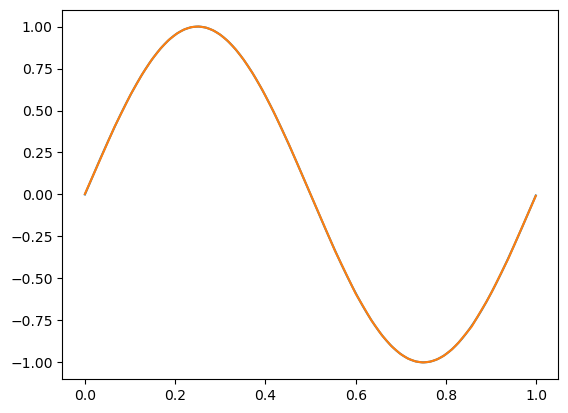

In [118]:
import matplotlib.pyplot as plt
X_test, y_test = sine_data()

prediction = model.predict(X_test)

plt.plot(X_test, y_test)
plt.plot(X_test, prediction)
plt.show()

## Download the MNIST Fashion Dataset for a real world use case

In [ ]:
from zipfile import ZipFile
import os
import urllib
import urllib.request

URL = 'https://nnfs.io/datasets/fashion_mnist_images.zip'
FILE = 'fashion_mnist_images.zip'
FOLDER = 'fashion_mnist_images'

if not os.path.isfile(FILE):
    print(f'Downloading {URL} and saving as {FILE}...')
    urllib.request.urlretrieve(URL, FILE)
    
print('Unzipping images...')
with ZipFile(FILE) as zip_images:
    zip_images.extractall(FOLDER)
    
print('Done!')

## Loading the MNIST Fashion Dataset

In [119]:
import cv2
import os

def load_mnist_dataset(dataset, path):
    labels = os.listdir(os.path.join(path, dataset))
    X = []
    y = []

    for label in labels:
        for file in os.listdir(os.path.join(path, dataset, label)):
            image = cv2.imread(os.path.join(path, dataset, label, file), cv2.IMREAD_UNCHANGED)
            X.append(image)
            y.append(label)
    
    return np.array(X), np.array(y).astype('uint8')

def create_data_mnist(path):
    X, y = load_mnist_dataset('train', path)
    X_test, y_test = load_mnist_dataset('test', path)
    return X, y, X_test, y_test

X, y, X_test, y_test = create_data_mnist('fashion_mnist_images')

## Data Preprocessing

In [120]:
keys = np.array(range(X.shape[0]))
np.random.shuffle(keys)
X = X[keys]
y = y[keys]

X = (X.reshape(X.shape[0], -1).astype(np.float32) - 127.5) / 127.5
X_test = (X_test.reshape(X_test.shape[0], -1).astype(np.float32) - 127.5) / 127.5

In [121]:
model = Model()
model.add(Dense_Layer(X.shape[1], 128))
model.add(Relu_Activation())
model.add(Dense_Layer(128, 128))
model.add(Relu_Activation())
model.add(Dense_Layer(128, 10))
model.add(Softmax_Activation())

model.set(loss=Categorical_CrossEntropy(), optimizer=Adam_Optimizer(decay=5e-5), accuracy=Accuracy_Categorical())
model.finalize()

model.train(X, y, validation_data=(X_test, y_test), epochs=5, batch_size=128, print_every_epoch=1, print_every_step=468)

Epoch:  1
Step: 0, Accuracy: 0.055, Loss: 2.303 (Data Loss: 2.303, Regularization Loss: 0.000), Learning Rate: 0.001
Step: 468, Accuracy: 0.896, Loss: 0.320 (Data Loss: 0.320, Regularization Loss: 0.000), Learning Rate: 0.0009771350400625367
Training, Accuracy: 0.769, Loss: 0.636 (Data Loss: 0.636, Regularlization Loss: 0.000), Learning Rate: 0.0009771350400625367

Validation, Accuracy: 0.820, Loss: 0.479

Epoch:  2
Step: 0, Accuracy: 0.859, Loss: 0.434 (Data Loss: 0.434, Regularization Loss: 0.000), Learning Rate: 0.0009770873027505008
Step: 468, Accuracy: 0.865, Loss: 0.284 (Data Loss: 0.284, Regularization Loss: 0.000), Learning Rate: 0.0009552466924583273
Training, Accuracy: 0.848, Loss: 0.414 (Data Loss: 0.414, Regularlization Loss: 0.000), Learning Rate: 0.0009552466924583273

Validation, Accuracy: 0.847, Loss: 0.417

Epoch:  3
Step: 0, Accuracy: 0.883, Loss: 0.391 (Data Loss: 0.391, Regularization Loss: 0.000), Learning Rate: 0.0009552010698251983
Step: 468, Accuracy: 0.875, Los